## 1. Imports and Setup

We start by importing the necessary libraries.

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

## 2. Load Dataset

We load the cleaned resumes dataset from the CSV file.

In [37]:
df = pd.read_csv('cleaned_resumes.csv')
print(f"Dataset shape: {df.shape}")

Dataset shape: (2100, 17)


## 3. Automatic Feature Selection

We automatically identify the feature columns by excluding the target variable and any non-predictive metadata.

In [38]:
TARGET = 'experience_level'
ID_COLS = {'name', 'email', 'linkedin', 'github'}

feature_cols = [c for c in df.columns if c != TARGET and c not in ID_COLS]
print(f"Selected Features: {feature_cols}")

for col in feature_cols:
    df[col] = df[col].astype(str).fillna('')

X = df[feature_cols]
y = df[TARGET]

Selected Features: ['summary', 'experience', 'education', 'skills', 'projects', 'certifications', 'summary_count', 'last_experience_only', 'total_experience_time', 'last_experience_time', 'job title', 'target_experience_text']


## 4. Data Splitting

We split the data into training (80%) and testing (20%) sets using stratified splitting.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 1680
Testing samples: 420


## 5. Feature Engineering Pipeline (Weighted)

**Improvements**:
1.  **Feature Weights**: We keep the boosts for 'Total Experience' (5x) and 'Job Title' (3x).
2.  **3-Grams**: We use `ngram_range=(1, 3)` to capture longer phrases (e.g. "senior software engineer"), which helps disambiguate "Mid" roles.

In [40]:
transformers = []

# Define weights for specific columns to boost their importance
weights = {
    'total_experience_time': 5.0,
    'last_experience_time': 3.0,
    'job title': 3.0,
    'summary': 1.5,
    'experience': 2.0
}

# Prepare transformer weights dictionary
transformer_weights = {}

for col in feature_cols:
    name = f'tfidf_{col}'
    # Restoring (1, 3) n-grams
    transformers.append(
        (name, TfidfVectorizer(ngram_range=(1, 3), min_df=2, max_features=1000), col)
    )
    if col in weights:
        transformer_weights[name] = weights[col]

preprocessor = ColumnTransformer(
    transformers=transformers,
    remainder='drop',
    transformer_weights=transformer_weights
)

print("Feature Weights Applied:", weights)

Feature Weights Applied: {'total_experience_time': 5.0, 'last_experience_time': 3.0, 'job title': 3.0, 'summary': 1.5, 'experience': 2.0}


## 6. Model Training (Random Forest with Class Weights)

**Restored Improvement**: We apply `class_weight={'mid': 2.0, ...}`. This penalizes the model more for getting 'Mid' wrong, encouraging it to focus on correctly classifying the difficult middle class.

In [41]:
# Restoring class weights to boost Mid performance
class_weights = {'junior': 1.0, 'mid': 3.0, 'senior': 1.0}

rf_model = RandomForestClassifier(
    n_estimators=200, 
    n_jobs=-1, 
    random_state=42,
    class_weight=class_weights
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', rf_model)
])

print(f"Training Random Forest with Class Weights: {class_weights}...")
pipeline.fit(X_train, y_train)
print("Training Complete.")

Training Random Forest with Class Weights: {'junior': 1.0, 'mid': 3.0, 'senior': 1.0}...
Training Complete.


## 7. Evaluation

We evaluate the Random Forest model performance.

Accuracy: 0.5500
Classification Report:
              precision    recall  f1-score   support

      junior       0.58      0.76      0.66       140
         mid       0.48      0.30      0.37       140
      senior       0.56      0.59      0.57       140

    accuracy                           0.55       420
   macro avg       0.54      0.55      0.53       420
weighted avg       0.54      0.55      0.53       420



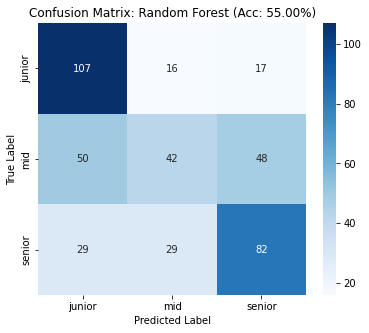

In [42]:
y_pred = pipeline.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=['junior', 'mid', 'senior'])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['junior', 'mid', 'senior'], 
            yticklabels=['junior', 'mid', 'senior'])
plt.title(f'Confusion Matrix: Random Forest (Acc: {acc:.2%})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()